# Sentiment Analysis

### Imports

In [1]:
import re
import spacy
import torch
import string
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords, opinion_lexicon
from sklearn.feature_extraction.text import TfidfVectorizer

### Loading Dataset
Dataset: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [2]:
df = pd.read_csv('dataset/IMDB_Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Removing for null and Deuplicated values

In [3]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
df.duplicated().sum()

np.int64(418)

## Lable Encoding target

In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
# LE = lable encoded
lable_map = {
    'positive' : 1,
    'negative' : 0
}
df['sentiment_LE'] = df['sentiment'].map(lable_map)
df

,review,sentiment,sentiment_LE
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


In [7]:
df['sentiment_LE'].value_counts()

sentiment_LE
1    25000
0    25000
Name: count, dtype: int64

## Ploting sentiment count

In [8]:
sentiment_counts = df['sentiment'].value_counts()

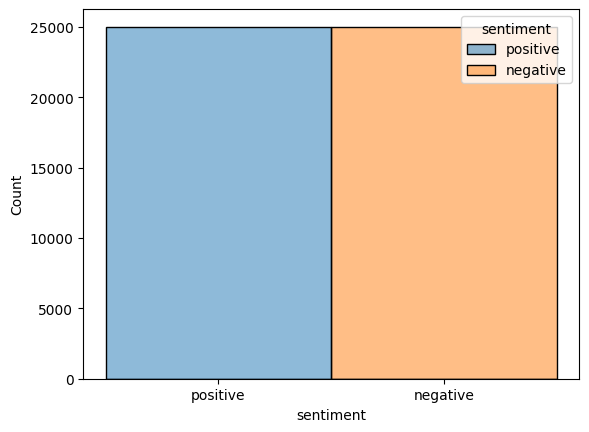

In [9]:
sns.histplot(data=df, x='sentiment', hue='sentiment')
plt.show()

## Removig HTML, punctuation and english stop words

In [12]:
n = 2
df['review'][n]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [13]:
nlp = spacy.load('en_core_web_sm')
custom_stop_word = {"movie", "film"}
def clean_text(s):
    # remove HTML tags
    s = re.sub(r"<.*?>", "", s)
    doc = nlp(s)
    return " ".join([
        token.lemma_   # normalize to lemma + lowercase
        for token in doc
        if not token.is_stop   # drop stopwords
        and not token.is_punct # drop punctuation
        and token.lemma_.lower() not in custom_stop_word  # drop custom stop words
    ])

clean_text(df['review'][n])

'think wonderful way spend time hot summer weekend sit air condition theater watch light hearted comedy plot simplistic dialogue witty character likable bread suspect serial killer disappoint realize Match Point 2 Risk Addiction think proof Woody Allen fully control style grow love laugh Woody comedy year dare decade impress Scarlet Johanson manage tone sexy image jump right average spirited young woman crown jewel career witty Devil Wears Prada interesting Superman great comedy friend'

In [14]:
df['clean_review'] = df['review'].apply(clean_text)

## Word clouds

In [15]:
all_raw_text = ' '.join(df['review'].astype(str))
all_cleaned_text = ' '.join(df['clean_review'].astype(str))

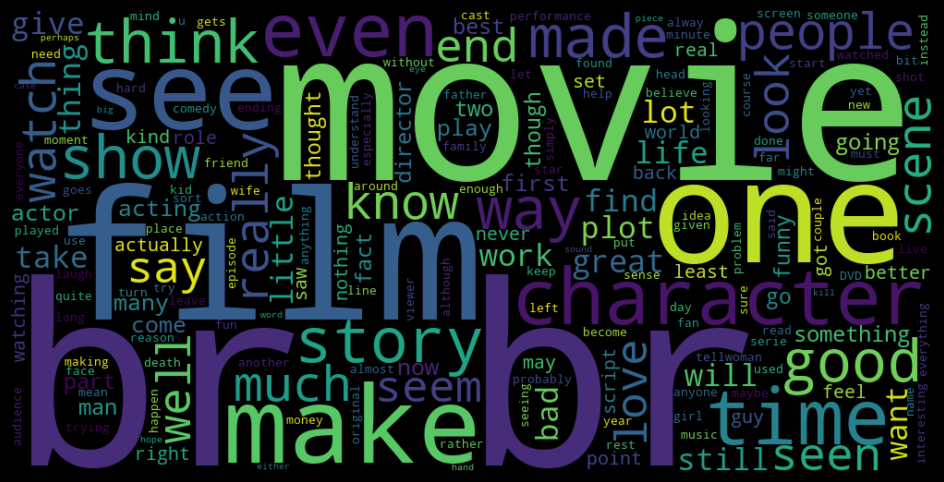

In [16]:
## raw text
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='black',
    max_words=200
).generate(all_raw_text)

plt.figure(figsize=(12,6), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

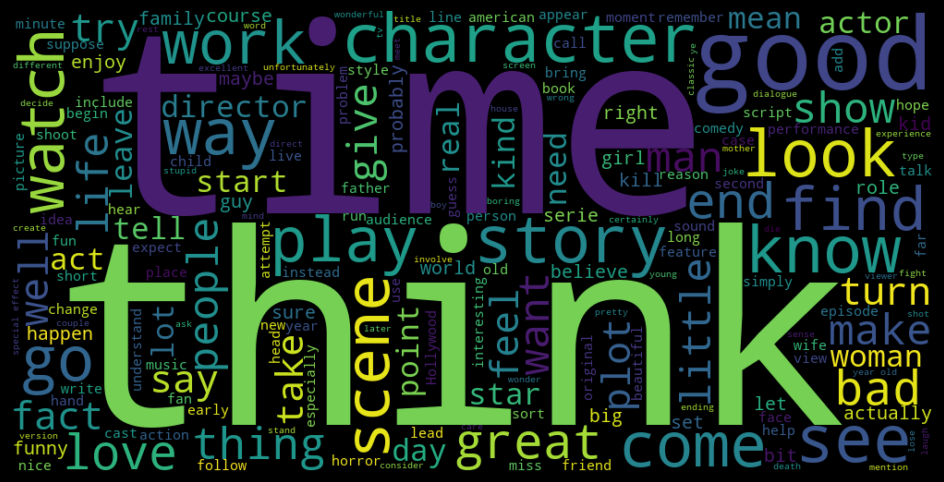

In [17]:
## cleaned text
wordcloud = WordCloud(
    width=1000, height=500,
    background_color="black",
    max_words=200
).generate(all_cleaned_text)

plt.figure(figsize=(12,6), facecolor='black')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [18]:
del all_raw_text
del all_cleaned_text

## Countig number of words

In [19]:
df['clean_review_word_len'] = df['clean_review'].apply(lambda x: len(x.split()))
df['clean_review_word_len']

0        141
1         76
2         73
3         54
4        107
        ... 
49995     56
49996     53
49997     95
49998     98
49999     45
Name: clean_review_word_len, Length: 50000, dtype: int64

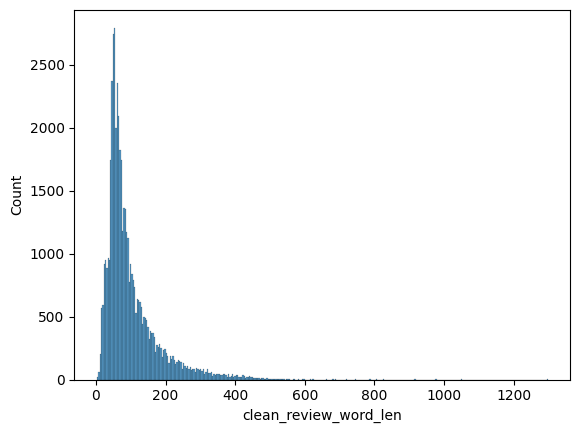

In [20]:
sns.histplot(df['clean_review_word_len'])
plt.show()

## counting positive and negative words

In [21]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())
def count_positive_words(sentence):
    doc = nlp(sentence)
    pos_count = 0
    for token in doc:
        word = token.text.lower()
        if word in positive_words:
            pos_count += 1
    return pos_count

def count_negative_words(sentence):
    doc = nlp(sentence)
    neg_count = 0
    for token in doc:
        word = token.text.lower()
        if word in negative_words:
            neg_count += 1
    return neg_count

In [22]:
n = 1
df['clean_review'][n], df['sentiment'][n]

('wonderful little production filming technique unassuming- old time BBC fashion give comforting discomforte sense realism entire piece actor extremely chosen- Michael Sheen get polari voice pat truly seamless editing guide reference Williams diary entry worth watching terrificly write perform piece masterful production great master comedy life realism come home little thing fantasy guard use traditional dream technique remain solid disappear play knowledge sense particularly scene concern Orton Halliwell set particularly flat Halliwell mural decorate surface terribly',
 'positive')

In [23]:
pos = count_positive_words(df['clean_review'][n])
neg = count_negative_words(df['clean_review'][n])
pos, neg

(8, 2)

In [24]:
pos_counts = df['clean_review'].apply(count_positive_words)
pos_counts

0        12
1         8
2        12
3         1
4        15
         ..
49995    14
49996     4
49997     6
49998     8
49999     4
Name: clean_review, Length: 50000, dtype: int64

In [25]:
neg_counts = df['clean_review'].apply(count_negative_words)
neg_counts

0        20
1         2
2         7
3         7
4         2
         ..
49995     1
49996    11
49997    13
49998    16
49999     7
Name: clean_review, Length: 50000, dtype: int64

In [26]:
pos_neg_ratio = pos_counts / neg_counts
pos_neg_ratio

0         0.600000
1         4.000000
2         1.714286
3         0.142857
4         7.500000
           ...    
49995    14.000000
49996     0.363636
49997     0.461538
49998     0.500000
49999     0.571429
Name: clean_review, Length: 50000, dtype: float64

In [27]:
df['pos_neg_ratio'] = pos_neg_ratio
del pos_neg_ratio
df['pos_counts'] = pos_counts
del pos_counts
df['neg_counts'] = neg_counts
del neg_counts

In [28]:
df[['sentiment', 'pos_neg_ratio', 'pos_counts', 'neg_counts']]

,sentiment,pos_neg_ratio,pos_counts,neg_counts
0,positive,0.600000,12,20
1,positive,4.000000,8,2
2,positive,1.714286,12,7
3,negative,0.142857,1,7
4,positive,7.500000,15,2
...,...,...,...,...
49995,positive,14.000000,14,1
49996,negative,0.363636,4,11
49997,negative,0.461538,6,13
49998,negative,0.500000,8,16


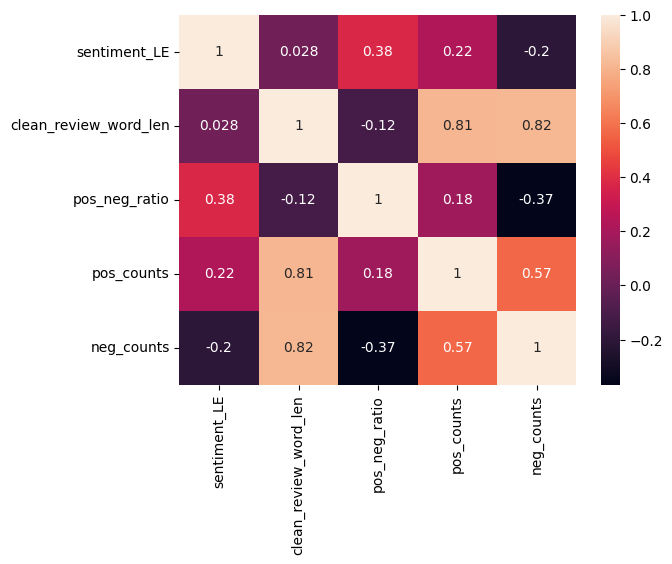

In [29]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

## TfidfVectorizer

In [30]:
tfid = TfidfVectorizer(
    max_features=10000, 
    min_df=2,
    ngram_range=(1,3)
)
v = tfid.fit_transform(df['clean_review'])

In [31]:
v.get_shape()

(50000, 10000)

In [32]:
tfid.get_feature_names_out()

array(['00', '000', '000 000', ..., 'zombies', 'zone', 'zoom'],
      shape=(10000,), dtype=object)

In [33]:
tfid_df = pd.DataFrame(v.toarray(), columns=tfid.get_feature_names_out())
tfid_df['sentiment_LE'] = df['sentiment_LE']
tfid_df

,00,000,000 000,007,10,10 10,10 line,10 minute,10 star,10 time,...,zeta jones,zhang,zizek,zoey,zombi,zombie,zombies,zone,zoom,sentiment_LE
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.062321,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.21709,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.0,0.077161,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,1
49996,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0
49997,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0
49998,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0


In [34]:
pos_df = tfid_df[tfid_df['sentiment_LE'] == 1].drop(columns=['sentiment_LE'])
neg_df = tfid_df[tfid_df['sentiment_LE'] == 0].drop(columns=['sentiment_LE'])

# Word frequencies (TF-IDF sums)
n = 20
pos_word_freq = pos_df.sum(axis=0).sort_values(ascending=False).head(n)
neg_word_freq = neg_df.sum(axis=0).sort_values(ascending=False).head(n)

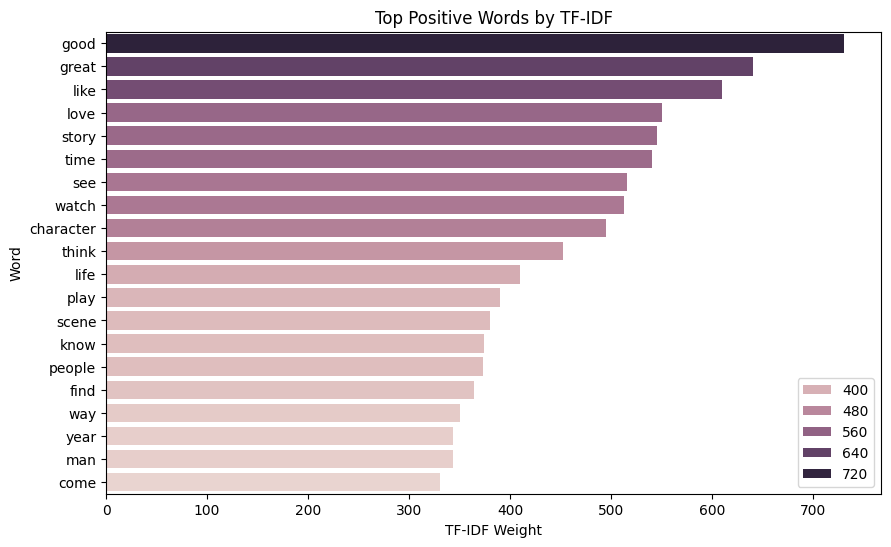

In [35]:
# Plot Positive words
plt.figure(figsize=(10, 6))
sns.barplot(x=pos_word_freq.values, y=pos_word_freq.index, hue=pos_word_freq.values)
plt.title("Top Positive Words by TF-IDF")
plt.xlabel("TF-IDF Weight")
plt.ylabel("Word")
plt.show()

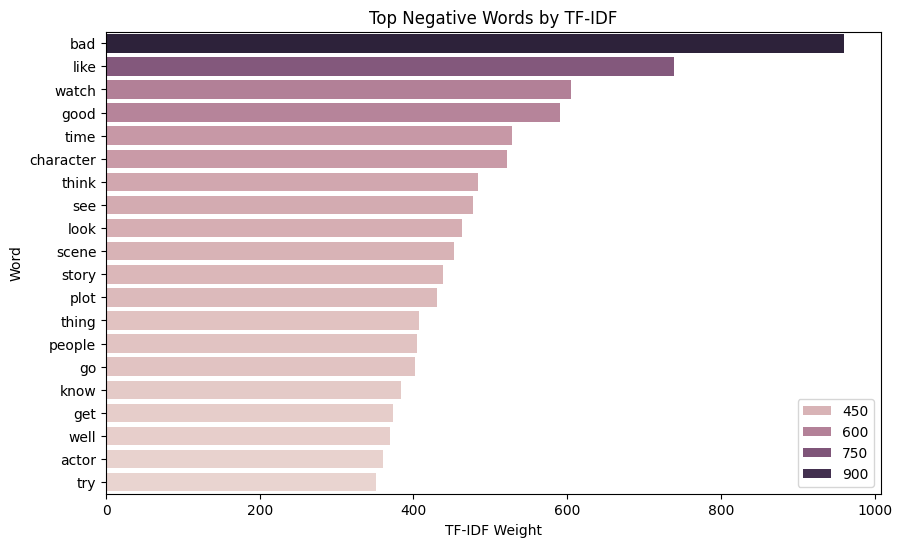

In [36]:
# Plot Negative words
plt.figure(figsize=(10, 6))
sns.barplot(x=neg_word_freq.values, y=neg_word_freq.index, hue=neg_word_freq.values)
plt.title("Top Negative Words by TF-IDF")
plt.xlabel("TF-IDF Weight")
plt.ylabel("Word")
plt.show()

In [37]:
df.to_csv('dataset/df.csv')
tfid_df.to_csv('dataset/tfid_df.csv')